In [1]:
import os 
import pandas as pd 
import numpy as np 
import functools
import multiprocessing 
import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


BASE_DIR = '/nfs/turbo/coe-rbg/mmakar/multiple_shortcut/chexpert/'

## Helper functions

In [2]:
def create_bootstraps(random_seed, fixed_joint, aux_joint_skew):
    """ Function to create bootstrap replicates and save them to disk"""
    experiment_directory = (f'{BASE_DIR}/experiment_data/rs{random_seed}')
        
    if fixed_joint:
        if aux_joint_skew == 0.9:
            test_data_str = 'fj09_test'
        else: 
            test_data_str = 'fj05_test'
    else: 
        test_data_str = 'test'
        
    for pskew in [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]: 
        bootstrap_file = f'{experiment_directory}/bootstrap_replicates_{pskew}_{test_data_str}.csv'
        if os.path.exists(bootstrap_file):
            print(f"Skipping pskew = {pskew}, and test data {test_data_str} because bootstraps exist")
            continue 
            
        test_data = pd.read_csv(
                f'{experiment_directory}/{pskew}_{test_data_str}.txt'
            ).values.tolist()
        test_data = [
            tuple(test_data[i][0].split(',')) for i in range(len(test_data))
        ]
        n = len(test_data)
        
        bs_ids = np.random.choice(range(n), size=1000*1000, replace=True)
        bs_ids = pd.DataFrame(data = np.split(bs_ids, 1000))
        bs_ids.to_csv(bootstrap_file, index=False)

        

In [3]:
def evaluate_predictions(pred_df):
    """function to evaluate predictions"""
    # --- get auroc 
    auroc = roc_auc_score(pred_df.y, pred_df.predictions)
    
    # --- get accuracy 
    pred_df['correct_class'] = 1.0*(pred_df.pred_class == pred_df.y)
    acc = np.mean(pred_df.correct_class)

    # --- get brier score 
    bsc = np.mean((pred_df.predictions - pred_df.y)**2)
 
    # -- get logistic loss 
    pred_df['predictions'] = np.where(pred_df['predictions'] < 0.001, 0.001, 
                             np.where(pred_df['predictions'] > 1-0.001, 1-0.001, 
                                     pred_df['predictions']))
    log_loss = pred_df.y * np.log(pred_df['predictions']) + \
        (1.0 - pred_df.y) * np.log(1.0 - pred_df['predictions'])
    log_loss = np.mean(log_loss)
    
    return pd.DataFrame({
        'model': pred_df.model.iloc[0], 
        'auroc': auroc, 
        'acc': acc, 
        'bsc': bsc, 
        'log_loss': log_loss
    }, index = [0])

In [4]:
def get_bootstrap_pskew_evaluations(bootstrap_id, predictions, pskew,
                                    fixed_joint, aux_joint_skew, random_seed):
    """ function that evaluates predictions of a single bootstrap replicate
        and a single pskew
    """
    experiment_directory = (f'{BASE_DIR}/experiment_data/rs{random_seed}')
    if fixed_joint:
        if aux_joint_skew == 0.9:
            test_data_str = 'fj09_test'
        else: 
            test_data_str = 'fj05_test'
    else: 
        test_data_str = 'test'
        
    # --- get the bootstrap ids 
    bs_ids = pd.read_csv(
        f'{experiment_directory}/bootstrap_replicates_{pskew}_{test_data_str}.csv', 
        usecols=[bootstrap_id]
    )
    bs_ids = bs_ids.squeeze().tolist()

    # -- get the results for the pskew dataset 
    predictions = predictions[(predictions.pskew == pskew)].reset_index(drop=True)
    predictions = predictions.iloc[bs_ids].reset_index(drop=True)

    # -- evaluate
    return evaluate_predictions(predictions)    

In [5]:
def get_bootstrap_evaluations(all_predictions, fixed_joint, aux_joint_skew, 
                              random_seed, num_workers):
    """ function that gets evaluations of all bootstrap replicates, 
        all pskew
    """
    # this will hold results of all pskews, bs reps 
    # ie it will have a length of pskew x # bs reps (1000)
    all_pskew_results = []
    for pskew in all_predictions.pskew.unique():
        print(f'Pskew = {pskew}')
        # this will hold the results of a single pskew, from 
        # all bootstrap replicates. 
        # ie it will have a length = # of replicates (1000)
        all_bootstrap_results = []
        if num_workers == 0: 
            for bootstrap_id in range(1000):
                res = get_bootstrap_pskew_evaluations(
                    bootstrap_id=bootstrap_id, 
                    predictions=all_predictions,
                    pskew=pskew,
                    fixed_joint=fixed_joint,
                    aux_joint_skew=aux_joint_skew, 
                    random_seed=random_seed
                )
                all_bootstrap_results.append(res)
        else: 
            get_bootstrap_pskew_evaluations_wrapper = functools.partial(
                get_bootstrap_pskew_evaluations, 
                predictions=all_predictions,
                pskew=pskew, 
                fixed_joint=fixed_joint,
                aux_joint_skew=aux_joint_skew, 
                random_seed=random_seed
            )
            pool = multiprocessing.Pool(num_workers)
            for res in tqdm.tqdm(pool.imap_unordered(
                get_bootstrap_pskew_evaluations_wrapper, range(1000)),total=1000):
                all_bootstrap_results.append(res)
                
        all_bootstrap_results = pd.concat(all_bootstrap_results, ignore_index=True)
        all_bootstrap_results['pskew'] = pskew 
        all_pskew_results.append(all_bootstrap_results)
        
    all_pskew_results = pd.concat(all_pskew_results, ignore_index=True)
    print(all_pskew_results.shape)
    all_pskew_results = all_pskew_results.groupby(['pskew', 'model']).agg([np.mean, np.std])
    all_pskew_results.reset_index(inplace =True)
    all_pskew_results.columns = [
        '_'.join(col).strip() for col in all_pskew_results.columns.values
    ]
    return all_pskew_results

## Bootstrap evaluation 

In [9]:
create_bootstraps(random_seed=0, fixed_joint=True, aux_joint_skew=0.5)

In [10]:
experiment_name = 'skew_train'
pixel = 128 
batch_size = 64
fixed_joint = True 
aux_joint_skew = 0.5
random_seed = 0 
num_workers = 0

In [11]:
model_name = 'weighted_hsic'
xv_mode = 'two_step'
wh_pred = pd.read_csv(
    (f'{BASE_DIR}/final_models/optimal_pred_{model_name}_{xv_mode}_{experiment_name}'
     f'_pix{pixel}_bs{batch_size}.csv'))

wh_eval = get_bootstrap_evaluations(
    all_predictions=wh_pred,
    fixed_joint=fixed_joint,
    aux_joint_skew=aux_joint_skew,
    random_seed=random_seed,
    num_workers = num_workers)

Pskew = 0.1
Pskew = 0.5
Pskew = 0.9
(3000, 6)


In [12]:
model_name = 'unweighted_hsic'
xv_mode = 'two_step'
uwh_pred = pd.read_csv(
    (f'{BASE_DIR}/final_models/optimal_pred_{model_name}_{xv_mode}_{experiment_name}'
     f'_pix{pixel}_bs{batch_size}.csv'))

uwh_eval = get_bootstrap_evaluations(
    all_predictions=uwh_pred,
    fixed_joint=fixed_joint,
    aux_joint_skew=aux_joint_skew,
    random_seed=random_seed,
    num_workers = num_workers)

Pskew = 0.1
Pskew = 0.5
Pskew = 0.9
(3000, 6)


In [13]:
model_name = 'unweighted_baseline'
xv_mode = 'classic'
uwb_pred = pd.read_csv(
    (f'{BASE_DIR}/final_models/optimal_pred_{model_name}_{xv_mode}_{experiment_name}'
     f'_pix{pixel}_bs{batch_size}.csv'))

uwb_eval = get_bootstrap_evaluations(
    all_predictions=uwb_pred,
    fixed_joint=fixed_joint,
    aux_joint_skew=aux_joint_skew,
    random_seed=random_seed,
    num_workers = num_workers)

Pskew = 0.1
Pskew = 0.5
Pskew = 0.9
(3000, 6)


In [14]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
wb_pred = pd.read_csv(
    (f'{BASE_DIR}/final_models/optimal_pred_{model_name}_{xv_mode}_{experiment_name}'
     f'_pix{pixel}_bs{batch_size}.csv'))

wb_eval = get_bootstrap_evaluations(
    all_predictions=wb_pred,
    fixed_joint=fixed_joint,
    aux_joint_skew=aux_joint_skew,
    random_seed=random_seed,
    num_workers = num_workers)

Pskew = 0.1
Pskew = 0.5
Pskew = 0.9
(3000, 6)


In [15]:
bs_eval_df = pd.concat([wh_eval, uwh_eval, uwb_eval, wb_eval],
                       ignore_index=True)

In [9]:
bs_eval_df = pd.read_csv(f'{BASE_DIR}/results/bs_eval_fj{aux_joint_skew}.csv')


In [10]:
bs_eval_df = bs_eval_df[(bs_eval_df.model_ != 'weighted_hsic_two_step')]

In [11]:
bs_eval_df = pd.concat([bs_eval_df, wh_eval])
print(bs_eval_df.model_.value_counts())

unweighted_hsic_two_step       3
unweighted_baseline_classic    3
weighted_baseline_classic      3
weighted_hsic_two_step         3
Name: model_, dtype: int64


In [17]:
if not os.path.exists(f'{BASE_DIR}/results'):
    os.mkdir(f'{BASE_DIR}/results')

if fixed_joint: 
    bs_eval_df.to_csv(f'{BASE_DIR}/results/bs_eval_fj{aux_joint_skew}.csv', index=False)
else: 
    bs_eval_df.to_csv(f'{BASE_DIR}/results/bs_eval_vj.csv', index=False)

## Plotting functions

In [18]:
def get_line_plot(res, metric, metric_name, model_spec):
    for model in model_spec.keys():        
        plt.errorbar(res.pskew_[(res.model_==model)],
                     res[f'{metric}_mean'][(res.model_==model)],
                     yerr = res[f'{metric}_std'][(res.model_==model)],
                     label=model_spec[model]['label'], 
                     color= model_spec[model]['color'], 
                     capsize=5)
    plt.xlabel(
        r'$P(V=1 \mid Y=1) = P(V=0| Y=0)$ at test time')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [19]:
def get_bar_plot(res, metric, metric_name, model_spec):
    x = [i for i in range(len(res.pskew_.unique()))]
    bar_width = 0.2
    for model_id, model in enumerate(model_spec.keys()):        
        plt.bar([x_i + (model_id * bar_width) for x_i in x] ,
                     res[f'{metric}_mean'][(res.model_==model)],
                     yerr = res[f'{metric}_std'][(res.model_==model)],
                     label=model_spec[model]['label'], 
                     color= model_spec[model]['color'], 
                     width = bar_width, 
                     capsize=5, 
                     align='edge')
    plt.xlabel(
        r'$P(V1=0, V2=1 \mid Y=1) = P(V1=0, V2=0| Y=0)$ at test time')
    plt.xticks(ticks = [x_i + bar_width * (len(model_spec.keys()) / 2.0) for x_i in x ],
               labels=res.pskew_.unique().tolist())
    if metric == 'auroc':
        plt.ylim(bottom = 0.25)
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

## Plotting results

In [20]:
plt.figure(figsize=(7, 5))
font = {'size': 14, 'family': 'serif', 'serif': 'Computer Modern Roman'}
plt.rc('font', **font)
plt.rc('text', usetex=True)


model_spec = {
    'unweighted_baseline_classic': {'color': '#1f77b4', 'label':'DNN', 'clean_label':'DNN'}, 
    'unweighted_hsic_two_step': {'color':'#ff7f0e', 'label': 'HSIC', 'clean_label':'HSIC'},  
    'weighted_baseline_classic': {'color':'#2ca02c', 'label': 'W-DNN', 'clean_label':'W-DNN'},
    'weighted_hsic_two_step': {'color':'#d62728', 'label': 'W-HSIC', 'clean_label':'W-HSIC'}
}


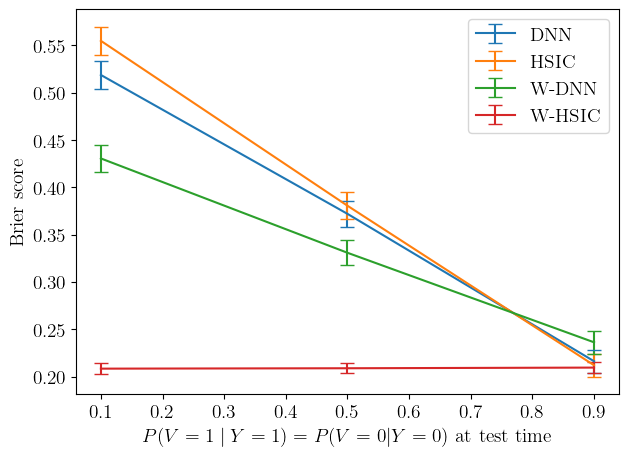

In [21]:
get_line_plot(bs_eval_df, 'bsc', 'Brier score', model_spec)

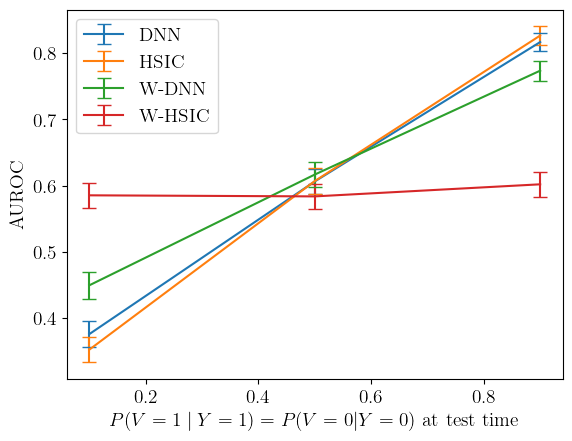

In [23]:
get_line_plot(bs_eval_df, 'auroc', 'AUROC', model_spec)

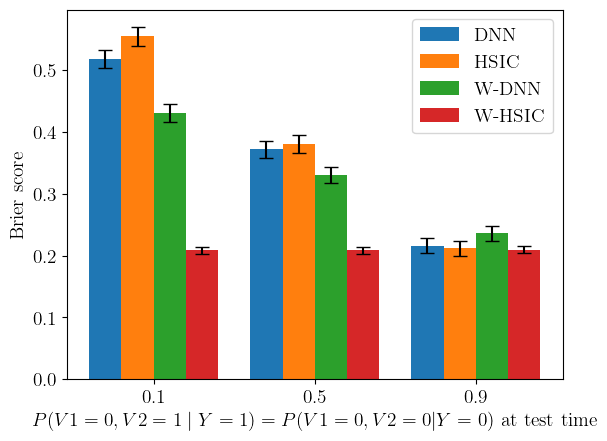

In [24]:
get_bar_plot(bs_eval_df, 'bsc', 'Brier score', model_spec)

In [ ]:
get_bar_plot(bs_eval_df, 'auroc', 'AUROC', model_spec)